# Clustering of Credit Card Users

MARIANO, Isaiah John L.

REGALARIO, Jeremiah Daniel A.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Read Parquet Files

## Customer Info Dataset

In [3]:
cust_info = pd.read_parquet('/content/drive/MyDrive/BPI Datasets/Customer Info.parquet')
cust_info.head()

,CUST_NUM,PROVINCE,REGION,EDUCATION,AGE,TENURE,BUSINESS_OWNER,DIGITAL_FLAG,INCOME_SOURCE,IDV_OR_ORG,SUBSEGMENT,GENDER,MARITAL_STATUS
0,1215.781230,TARLAC,REGION III (CENTRAL LUZON),NO_DATA,21.0,0.553425,N,DIGITAL,ALLOWANCE,INDIVIDUAL,Lower Tier,MALE,SINGLE
1,1357.977909,TARLAC,REGION III (CENTRAL LUZON),LOW,22.0,1.200000,N,TRADITIONAL,SALARY,INDIVIDUAL,Lower Tier,FEMALE,SINGLE
2,1437.499217,TARLAC,REGION III (CENTRAL LUZON),LOW,23.0,5.879452,N,TRADITIONAL,ALLOWANCE,INDIVIDUAL,Lower Tier,FEMALE,SINGLE
3,1606.444521,TARLAC,REGION III (CENTRAL LUZON),NO_DATA,13.0,2.345205,N,TRADITIONAL,ALLOWANCE,INDIVIDUAL,Upper-Middle Tier,FEMALE,SINGLE
4,2075.312988,TARLAC,REGION III (CENTRAL LUZON),LOW,22.0,0.353425,N,TRADITIONAL,SALARY,INDIVIDUAL,Lower Tier,MALE,SINGLE


In [4]:
cust_info.shape

(322812, 13)

## Credit Card Transactions Dataset

In [5]:
cred_trans = pd.read_parquet('/content/drive/MyDrive/BPI Datasets/Credit Card Txns.parquet')
cred_trans.head()

,CUST_NUM,MERCH_GROUP,DATE,AMOUNT,CHANNEL,MERCH_NAME,COUNTRY
0,12458.073687,Miscellaneous Stores,2024-01-15,-1.000000,PHYSICAL STORE PURCHASE,MERCHANT 81,PH
1,12802.502177,Miscellaneous Stores,2024-01-05,330.505264,PHYSICAL STORE PURCHASE,None,PH
2,7668.580181,Retail Outlet Services,2024-01-15,2002.673795,PHYSICAL STORE PURCHASE,MERCHANT 8,PH
3,8940.501216,Transportation Services,2024-03-16,72.211926,ONLINE PURCHASE,MERCHANT 37,PH
4,8017.532289,Utility Services,2024-02-01,3965.935680,ONLINE PURCHASE,MERCHANT 153,PH


In [6]:
cred_trans.shape

(1003585, 7)

# Data Cleaning

## Customer Information

### Summary Statistics and Information

In [ ]:
cust_info.describe(include='all')

,CUST_NUM,PROVINCE,REGION,EDUCATION,AGE,TENURE,BUSINESS_OWNER,DIGITAL_FLAG,INCOME_SOURCE,IDV_OR_ORG,SUBSEGMENT,GENDER,MARITAL_STATUS
count,322812.000000,322812,322812,322812,322608.000000,322812.000000,322812,322812,322812,322812,322812,322812,322812
unique,NaN,55,16,4,NaN,NaN,2,3,11,2,4,4,6
top,NaN,NATIONAL CAPITAL REGION,NATIONAL CAPITAL REGION,MID,NaN,NaN,N,TRADITIONAL,SALARY,INDIVIDUAL,Lower Tier,FEMALE,SINGLE
freq,NaN,138487,138487,171383,NaN,NaN,304009,123686,219875,322764,204964,187824,182401
mean,9427.336595,NaN,NaN,NaN,41.665225,8.358577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,3334.071813,NaN,NaN,NaN,15.348987,6.457856,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,8.000000,NaN,NaN,NaN,1.000000,0.254795,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,7071.054624,NaN,NaN,NaN,30.000000,3.104110,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,9999.002650,NaN,NaN,NaN,38.000000,7.013699,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,12247.337813,NaN,NaN,NaN,50.000000,11.827397,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
cust_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 322812 entries, 0 to 305159
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   CUST_NUM        322812 non-null  float64
 1   PROVINCE        322812 non-null  object 
 2   REGION          322812 non-null  object 
 3   EDUCATION       322812 non-null  object 
 4   AGE             322608 non-null  float64
 5   TENURE          322812 non-null  float64
 6   BUSINESS_OWNER  322812 non-null  object 
 7   DIGITAL_FLAG    322812 non-null  object 
 8   INCOME_SOURCE   322812 non-null  object 
 9   IDV_OR_ORG      322812 non-null  object 
 10  SUBSEGMENT      322812 non-null  object 
 11  GENDER          322812 non-null  object 
 12  MARITAL_STATUS  322812 non-null  object 
dtypes: float64(3), object(10)
memory usage: 34.5+ MB


### Remove Duplicates

In [ ]:
cust_info_duplicates = cust_info.duplicated().sum()
print(f"Number of duplicates: {cust_info_duplicates}")

Number of duplicates: 1607


In [ ]:
cust_info.drop_duplicates(inplace=True)

In [ ]:
cust_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 321205 entries, 0 to 305163
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   CUST_NUM        321205 non-null  float64
 1   PROVINCE        321205 non-null  object 
 2   REGION          321205 non-null  object 
 3   EDUCATION       321205 non-null  object 
 4   AGE             321003 non-null  float64
 5   TENURE          321205 non-null  float64
 6   BUSINESS_OWNER  321205 non-null  object 
 7   DIGITAL_FLAG    321205 non-null  object 
 8   INCOME_SOURCE   321205 non-null  object 
 9   IDV_OR_ORG      321205 non-null  object 
 10  SUBSEGMENT      321205 non-null  object 
 11  GENDER          321205 non-null  object 
 12  MARITAL_STATUS  321205 non-null  object 
dtypes: float64(3), object(10)
memory usage: 34.3+ MB


### Check Unique Values

In [ ]:
dataset = cust_info

for column in dataset.columns:
  unique_count = dataset[column].nunique()
  unique_values = dataset[column].unique()

  print(f'''
{column}
  {unique_values}
Length: {unique_count}
''')


CUST_NUM
  [ 1215.78123032  1357.97790851  1437.49921739 ... 14062.05191286
 14092.26113865 14116.51175043]
Length: 321205


PROVINCE
  ['TARLAC' 'NATIONAL CAPITAL REGION' 'PAMPANGA' 'ILOILO' 'CAVITE'
 'MISAMIS ORIENTAL' 'RIZAL' 'LAGUNA' 'LANAO DEL NORTE' 'ILOCOS NORTE'
 'NEGROS OCCIDENTAL' 'PALAWAN' 'CEBU' 'CAMARINES SUR' 'MISAMIS OCCIDENTAL'
 'BULACAN' 'DAVAO DEL SUR' 'CAGAYAN' 'DAVAO DEL NORTE' 'LA UNION' 'BOHOL'
 'BATANGAS' 'ZAMBOANGA DEL NORTE' 'COTABATO CITY (NOT A PROVINCE)'
 'PANGASINAN' 'ILOCOS SUR' 'LEYTE' 'NUEVA ECIJA' 'ZAMBOANGA DEL SUR'
 'BENGUET' 'ORIENTAL MINDORO' 'QUEZON' 'ZAMBALES' 'CAPIZ' 'ISABELA'
 'AGUSAN DEL NORTE' 'ALBAY' 'AKLAN' 'AGUSAN DEL SUR' 'SOUTH COTABATO'
 'SURIGAO DEL NORTE' 'NEGROS ORIENTAL' 'ANTIQUE' 'BATAAN' 'SORSOGON'
 'SOUTHERN LEYTE' 'COTABATO (NORTH COTABATO)' 'CAMARINES NORTE'
 'NORTHERN SAMAR' 'BUKIDNON' 'DAVAO ORIENTAL' 'SURIGAO DEL SUR'
 'NUEVA VIZCAYA' 'SAMAR (WESTERN SAMAR)' 'SULTAN KUDARAT']
Length: 55


REGION
  ['REGION III (CENTRAL LUZON

### Convert MLE to MALE

In [ ]:
cust_info['GENDER'] = cust_info['GENDER'].str.replace('MLE', 'MALE')

In [ ]:
cust_info['GENDER'].unique()

array(['MALE', 'FEMALE', 'OTHERS'], dtype=object)

### Null Values Detection

In [ ]:
cust_info_nulls = cust_info.replace('NO_DATA', np.nan, inplace=False).isna().sum()
cust_info_nulls

CUST_NUM              0
PROVINCE              0
REGION                0
EDUCATION         78175
AGE                 202
TENURE                0
BUSINESS_OWNER        0
DIGITAL_FLAG      87402
INCOME_SOURCE      3604
IDV_OR_ORG            0
SUBSEGMENT            0
GENDER                0
MARITAL_STATUS        0
dtype: int64

<Axes: >

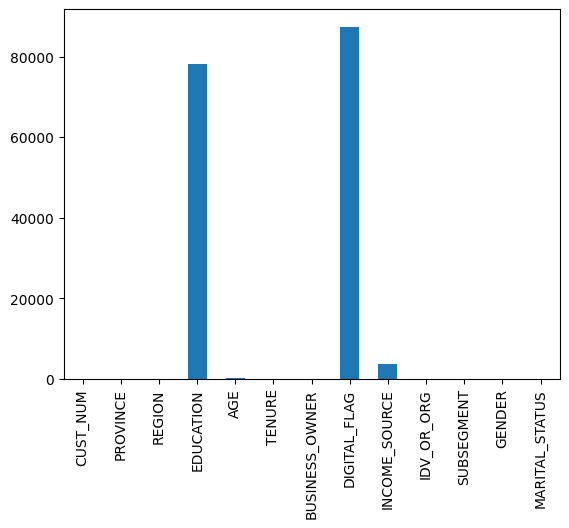

In [ ]:
cust_info_nulls.plot(kind='bar')

In [ ]:
total_cust_info = len(cust_info)
(cust_info_nulls / total_cust_info) * 100

CUST_NUM           0.000000
PROVINCE           0.000000
REGION             0.000000
EDUCATION         24.338040
AGE                0.062888
TENURE             0.000000
BUSINESS_OWNER     0.000000
DIGITAL_FLAG      27.210660
INCOME_SOURCE      1.122025
IDV_OR_ORG         0.000000
SUBSEGMENT         0.000000
GENDER             0.000000
MARITAL_STATUS     0.000000
dtype: float64

In [ ]:
cust_info.head()

,CUST_NUM,PROVINCE,REGION,EDUCATION,AGE,TENURE,BUSINESS_OWNER,DIGITAL_FLAG,INCOME_SOURCE,IDV_OR_ORG,SUBSEGMENT,GENDER,MARITAL_STATUS
0,1215.781230,TARLAC,REGION III (CENTRAL LUZON),NO_DATA,21.0,0.553425,N,DIGITAL,ALLOWANCE,INDIVIDUAL,Lower Tier,MALE,SINGLE
1,1357.977909,TARLAC,REGION III (CENTRAL LUZON),LOW,22.0,1.200000,N,TRADITIONAL,SALARY,INDIVIDUAL,Lower Tier,FEMALE,SINGLE
2,1437.499217,TARLAC,REGION III (CENTRAL LUZON),LOW,23.0,5.879452,N,TRADITIONAL,ALLOWANCE,INDIVIDUAL,Lower Tier,FEMALE,SINGLE
3,1606.444521,TARLAC,REGION III (CENTRAL LUZON),NO_DATA,13.0,2.345205,N,TRADITIONAL,ALLOWANCE,INDIVIDUAL,Upper-Middle Tier,FEMALE,SINGLE
4,2075.312988,TARLAC,REGION III (CENTRAL LUZON),LOW,22.0,0.353425,N,TRADITIONAL,SALARY,INDIVIDUAL,Lower Tier,MALE,SINGLE


## Credit Card Transactions

### Summary Statistics and Information

In [ ]:
cred_trans.describe(include='all')

,CUST_NUM,MERCH_GROUP,DATE,AMOUNT,CHANNEL,MERCH_NAME,COUNTRY
count,1.003585e+06,941892,1003585,1.003585e+06,1003585,808477,1000362
unique,NaN,13,NaN,NaN,3,2150,40
top,NaN,Miscellaneous Stores,NaN,NaN,PHYSICAL STORE PURCHASE,MERCHANT 37,PH
freq,NaN,346473,NaN,NaN,561882,125815,803371
mean,9.486952e+03,NaN,2024-02-15 16:08:07.477991,3.363621e+03,NaN,NaN,NaN
min,1.397212e+02,NaN,2024-01-01 00:00:00,-1.000000e+00,NaN,NaN,NaN
25%,7.137142e+03,NaN,2024-01-24 00:00:00,3.804385e+02,NaN,NaN,NaN
50%,1.010406e+04,NaN,2024-02-16 00:00:00,8.884761e+02,NaN,NaN,NaN
75%,1.229881e+04,NaN,2024-03-09 00:00:00,2.235465e+03,NaN,NaN,NaN
max,1.414168e+04,NaN,2024-03-31 00:00:00,2.000024e+06,NaN,NaN,NaN


There is a -1 value for the amount

In [ ]:
cred_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003585 entries, 0 to 1003584
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   CUST_NUM     1003585 non-null  float64       
 1   MERCH_GROUP  941892 non-null   object        
 2   DATE         1003585 non-null  datetime64[us]
 3   AMOUNT       1003585 non-null  float64       
 4   CHANNEL      1003585 non-null  object        
 5   MERCH_NAME   808477 non-null   object        
 6   COUNTRY      1000362 non-null  object        
dtypes: datetime64[us](1), float64(2), object(4)
memory usage: 53.6+ MB


### Check Duplicates

In [ ]:
cred_trans_duplicates = cred_trans.duplicated().sum()
print(f"Number of duplicates: {cred_trans_duplicates}")

Number of duplicates: 0


### Check Unique Values

In [ ]:
dataset = cred_trans

for column in dataset.columns:
  unique_count = dataset[column].nunique()
  unique_values = dataset[column].unique()

  print(f'''
{column}
  {unique_values}
Length: {unique_count}
''')


CUST_NUM
  [12458.07368737 12802.50217731  7668.58018149 ... 10263.96706932
 12362.38658189  5730.21849496]
Length: 39616


MERCH_GROUP
  ['Miscellaneous Stores' 'Retail Outlet Services' 'Transportation Services'
 'Utility Services' 'Clothing Stores' 'Lodging' None 'Business Services'
 'Professional Services and Membership Organizations' 'Airlines'
 'Government Services' 'Agricultural Services' 'Contracted Services'
 'Car Rental']
Length: 13


DATE
  <DatetimeArray>
['2024-01-15 00:00:00', '2024-01-05 00:00:00', '2024-03-16 00:00:00',
 '2024-02-01 00:00:00', '2024-01-29 00:00:00', '2024-03-30 00:00:00',
 '2024-01-22 00:00:00', '2024-03-14 00:00:00', '2024-01-24 00:00:00',
 '2024-01-13 00:00:00', '2024-01-18 00:00:00', '2024-02-24 00:00:00',
 '2024-03-27 00:00:00', '2024-03-01 00:00:00', '2024-03-07 00:00:00',
 '2024-03-11 00:00:00', '2024-01-02 00:00:00', '2024-02-06 00:00:00',
 '2024-01-28 00:00:00', '2024-03-21 00:00:00', '2024-01-03 00:00:00',
 '2024-03-25 00:00:00', '2024-02-03 00

### Check for Negative Value Transactions

<Axes: xlabel='AMOUNT'>

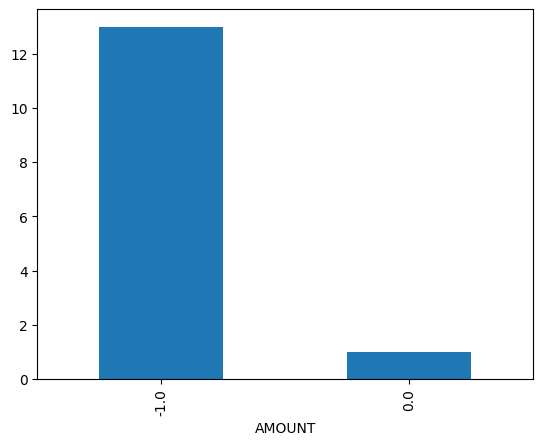

In [ ]:
cred_trans[(cred_trans['AMOUNT'] < 0) | (cred_trans['AMOUNT'] == 0)]['AMOUNT'].value_counts().plot(kind='bar')

Only few negative value transactions (only -1) and one 0

In [ ]:
cred_trans = cred_trans[cred_trans['AMOUNT'] > 0]
cred_trans.shape

(1003571, 7)

### Null Values Detection

In [ ]:
cred_trans_nulls = cred_trans.isna().sum()
cred_trans_nulls

CUST_NUM            0
MERCH_GROUP     61690
DATE                0
AMOUNT              0
CHANNEL             0
MERCH_NAME     195104
COUNTRY          3223
dtype: int64

<Axes: >

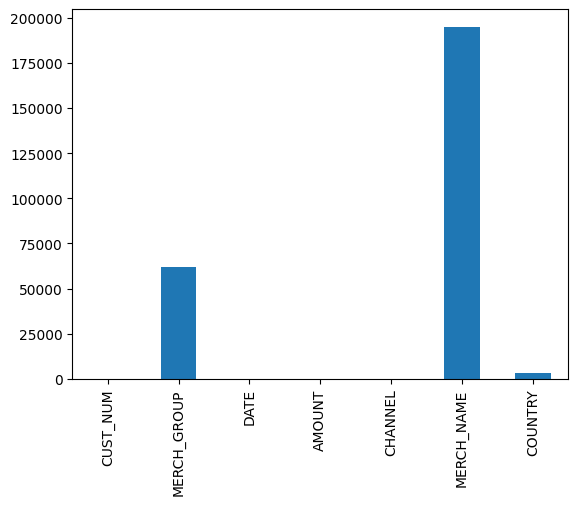

In [ ]:
cred_trans.isna().sum().plot(kind='bar')

In [ ]:
total_cred_trans = len(cred_trans)
(cred_trans_nulls / total_cred_trans) * 100

CUST_NUM        0.000000
MERCH_GROUP     6.147049
DATE            0.000000
AMOUNT          0.000000
CHANNEL         0.000000
MERCH_NAME     19.440976
COUNTRY         0.321153
dtype: float64

### Replace Null Value from `MERCH_GROUP` to `NO_NAME`

<Axes: xlabel='MERCH_GROUP'>

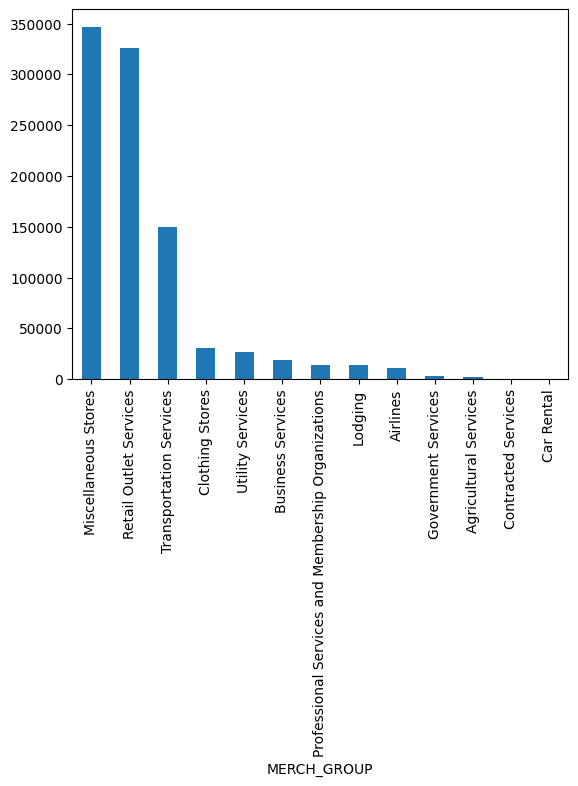

In [ ]:
cred_trans['MERCH_GROUP'].value_counts().plot(kind='bar')

In [ ]:
cred_trans['MERCH_GROUP'] = cred_trans['MERCH_GROUP'].replace(np.nan, 'NO_NAME')
cred_trans['MERCH_GROUP'].unique()

<ipython-input-280-5c15d29a9616>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cred_trans['MERCH_GROUP'] = cred_trans['MERCH_GROUP'].replace(np.nan, 'NO_NAME')


array(['Miscellaneous Stores', 'Retail Outlet Services',
       'Transportation Services', 'Utility Services', 'Clothing Stores',
       'Lodging', 'NO_NAME', 'Business Services',
       'Professional Services and Membership Organizations', 'Airlines',
       'Government Services', 'Agricultural Services',
       'Contracted Services', 'Car Rental'], dtype=object)

### Replace Null Value from `COUNTRY` to `PH`

<Axes: xlabel='COUNTRY'>

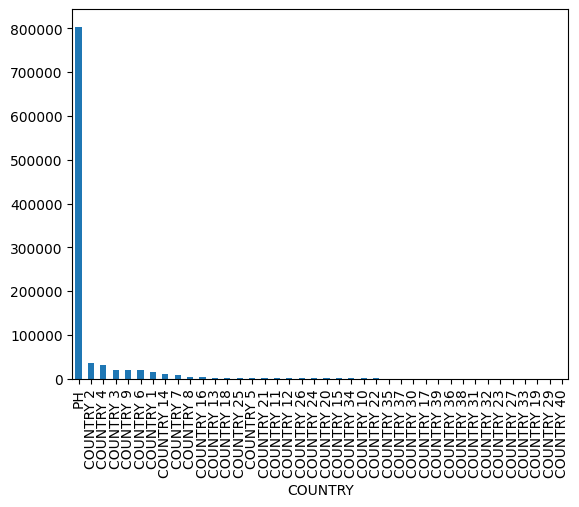

In [ ]:
cred_trans['COUNTRY'].value_counts().plot(kind='bar')

In [ ]:
cred_trans['COUNTRY'] = cred_trans['COUNTRY'].replace(np.nan, 'PH')
cred_trans['COUNTRY'].unique()

<ipython-input-282-c5a9e5e44636>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cred_trans['COUNTRY'] = cred_trans['COUNTRY'].replace(np.nan, 'PH')


array(['PH', 'COUNTRY 3', 'COUNTRY 9', 'COUNTRY 1', 'COUNTRY 26',
       'COUNTRY 2', 'COUNTRY 14', 'COUNTRY 6', 'COUNTRY 21', 'COUNTRY 8',
       'COUNTRY 16', 'COUNTRY 4', 'COUNTRY 7', 'COUNTRY 36', 'COUNTRY 30',
       'COUNTRY 20', 'COUNTRY 11', 'COUNTRY 5', 'COUNTRY 25',
       'COUNTRY 13', 'COUNTRY 15', 'COUNTRY 18', 'COUNTRY 12',
       'COUNTRY 34', 'COUNTRY 10', 'COUNTRY 39', 'COUNTRY 38',
       'COUNTRY 17', 'COUNTRY 35', 'COUNTRY 22', 'COUNTRY 24',
       'COUNTRY 27', 'COUNTRY 29', 'COUNTRY 23', 'COUNTRY 37',
       'COUNTRY 32', 'COUNTRY 33', 'COUNTRY 19', 'COUNTRY 31',
       'COUNTRY 40'], dtype=object)

### Drop `MERCH_NAME` column

In [ ]:
cred_trans.drop(columns=['MERCH_NAME'], inplace=True)
cred_trans.head()

<ipython-input-283-42bfa422f148>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cred_trans.drop(columns=['MERCH_NAME'], inplace=True)


,CUST_NUM,MERCH_GROUP,DATE,AMOUNT,CHANNEL,COUNTRY
1,12802.502177,Miscellaneous Stores,2024-01-05,330.505264,PHYSICAL STORE PURCHASE,PH
2,7668.580181,Retail Outlet Services,2024-01-15,2002.673795,PHYSICAL STORE PURCHASE,PH
3,8940.501216,Transportation Services,2024-03-16,72.211926,ONLINE PURCHASE,PH
4,8017.532289,Utility Services,2024-02-01,3965.935680,ONLINE PURCHASE,PH
5,13429.889873,Retail Outlet Services,2024-01-29,1787.981900,PHYSICAL STORE PURCHASE,PH


### Rename Columns

In [ ]:
suffix = "_cred"

col = ['MERCH_GROUP', 'DATE', 'AMOUNT', 'CHANNEL', 'COUNTRY']
columns_to_rename = {s: f"{s}{suffix}" for s in col}

cred_trans = cred_trans.rename(columns=columns_to_rename)
cred_trans.head()

,CUST_NUM,MERCH_GROUP_cred,DATE_cred,AMOUNT_cred,CHANNEL_cred,COUNTRY_cred
1,12802.502177,Miscellaneous Stores,2024-01-05,330.505264,PHYSICAL STORE PURCHASE,PH
2,7668.580181,Retail Outlet Services,2024-01-15,2002.673795,PHYSICAL STORE PURCHASE,PH
3,8940.501216,Transportation Services,2024-03-16,72.211926,ONLINE PURCHASE,PH
4,8017.532289,Utility Services,2024-02-01,3965.935680,ONLINE PURCHASE,PH
5,13429.889873,Retail Outlet Services,2024-01-29,1787.981900,PHYSICAL STORE PURCHASE,PH


### Save to Parquet Files

In [ ]:
cred_trans.to_parquet('/content/drive/MyDrive/BPI Clustering Project/cred_trans.parquet')
cust_info.to_parquet('/content/drive/MyDrive/BPI Clustering Project/cust_info.parquet')

# Feature Engineering

## RFM

In the datasets other than `CUSTOMER INFO`, the lengths of `CUST_NUM` are less than the unique values of `CUST_NUM`. The dates and transaction amounts differ in each unique `CUST_NUM`. So we created a new dataframe from each dataset with Recency, Frequency, and Total Transaction Amount. In this way, the `CUST_NUM` would be unique for the datasets other than `CUSTOMER INFO`. [(source)](https://connectif.ai/en/blog/what-are-rfm-scores-and-how-to-calculate-them/)

Lower Recency means most recent. Convert 0 Recency to 1 to mitigate -inf problem in logarithmic transformation used in modelling.

In [ ]:
def rep_0(i):
  return 1 if i == 0 else i

#### Credit Card Transactions

In [ ]:
from datetime import datetime

cred_trans['DATE_max_cred'] = cred_trans['DATE_cred']
cred_trans['DATE_min_cred'] = cred_trans['DATE_cred']
cred_trans['Frequency_cred'] = cred_trans['CUST_NUM']
reference_date = datetime(2024, 6, 24)

credit_trans_rfm = cred_trans.groupby("CUST_NUM").agg({
    "Frequency_cred": "count",
    "AMOUNT_cred": "sum",
    "DATE_max_cred": "max"
})

credit_trans_rfm = credit_trans_rfm.reset_index()

In [ ]:
credit_trans_rfm['Recency_cred'] = reference_date - credit_trans_rfm["DATE_max_cred"]
credit_trans_rfm['Recency_cred'] = credit_trans_rfm['Recency_cred'].astype(str)
credit_trans_rfm['Recency_cred'] = credit_trans_rfm['Recency_cred'].str.replace('days', '')

for s in credit_trans_rfm['Recency_cred']:
  credit_trans_rfm.replace(s, s.replace("  00:00:00", ""), inplace=True)

credit_trans_rfm['Recency_cred'] = credit_trans_rfm['Recency_cred'].astype(int)
credit_trans_rfm.drop(columns=['DATE_max_cred'], inplace=True)
credit_trans_rfm['Recency_cred'] = credit_trans_rfm['Recency_cred'].apply(rep_0)

credit_trans_rfm.head()

,CUST_NUM,Frequency_cred,AMOUNT_cred,Recency_cred
0,139.721151,41,157948.021517,86
1,142.625383,27,23276.127326,97
2,171.002924,20,27686.502369,86
3,206.014563,2,33385.440440,86
4,220.099977,15,10749.183223,87


In [ ]:
credit_trans_rfm.shape

(39616, 4)

#### Merged Dataset

In [ ]:
merged_df = cust_info.set_index('CUST_NUM').merge(credit_trans_rfm.set_index('CUST_NUM'), left_index=True, right_index=True, how='inner')
merged_df.head()

,PROVINCE,REGION,EDUCATION,AGE,TENURE,BUSINESS_OWNER,DIGITAL_FLAG,INCOME_SOURCE,IDV_OR_ORG,SUBSEGMENT,GENDER,MARITAL_STATUS,Frequency_cred,AMOUNT_cred,Recency_cred
CUST_NUM,,,,,,,,,,,,,,,
13401.256807,TARLAC,REGION III (CENTRAL LUZON),MID,23.0,1.295890,N,DIGITAL,SALARY,INDIVIDUAL,Lower Tier,MALE,SINGLE,17,4987.052711,85
3004.880031,NATIONAL CAPITAL REGION,NATIONAL CAPITAL REGION,NO_DATA,22.0,0.821918,N,DIGITAL,SALARY,INDIVIDUAL,Lower Tier,FEMALE,SINGLE,4,3315.591849,90
3205.814093,NATIONAL CAPITAL REGION,NATIONAL CAPITAL REGION,NO_DATA,22.0,3.271233,N,TRADITIONAL,SALARY,INDIVIDUAL,Lower Tier,FEMALE,SINGLE,16,55286.300324,91
3427.133496,NATIONAL CAPITAL REGION,NATIONAL CAPITAL REGION,NO_DATA,22.0,3.361644,N,DIGITAL,SALARY,INDIVIDUAL,Upper-Middle Tier,MALE,SINGLE,3,20828.764019,100
4230.004965,NATIONAL CAPITAL REGION,NATIONAL CAPITAL REGION,LOW,22.0,8.205479,N,DIGITAL,ALLOWANCE,INDIVIDUAL,Upper-Middle Tier,MALE,SINGLE,83,131910.554528,85


In [ ]:
merged_df.shape

(39616, 15)

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39616 entries, 13401.256806732717 to 13828.97696866981
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PROVINCE        39616 non-null  object 
 1   REGION          39616 non-null  object 
 2   EDUCATION       39616 non-null  object 
 3   AGE             39616 non-null  float64
 4   TENURE          39616 non-null  float64
 5   BUSINESS_OWNER  39616 non-null  object 
 6   DIGITAL_FLAG    39616 non-null  object 
 7   INCOME_SOURCE   39616 non-null  object 
 8   IDV_OR_ORG      39616 non-null  object 
 9   SUBSEGMENT      39616 non-null  object 
 10  GENDER          39616 non-null  object 
 11  MARITAL_STATUS  39616 non-null  object 
 12  Frequency_cred  39616 non-null  int64  
 13  AMOUNT_cred     39616 non-null  float64
 14  Recency_cred    39616 non-null  int64  
dtypes: float64(3), int64(2), object(10)
memory usage: 4.8+ MB


#### Merged Dataset Null Values

In [ ]:
merged_df_nulls = merged_df.replace('NO_DATA', np.nan, inplace=False).isnull().sum()
merged_df_nulls

PROVINCE             0
REGION               0
EDUCATION         3644
AGE                  0
TENURE               0
BUSINESS_OWNER       0
DIGITAL_FLAG      1028
INCOME_SOURCE      171
IDV_OR_ORG           0
SUBSEGMENT           0
GENDER               0
MARITAL_STATUS       0
Frequency_cred       0
AMOUNT_cred          0
Recency_cred         0
dtype: int64

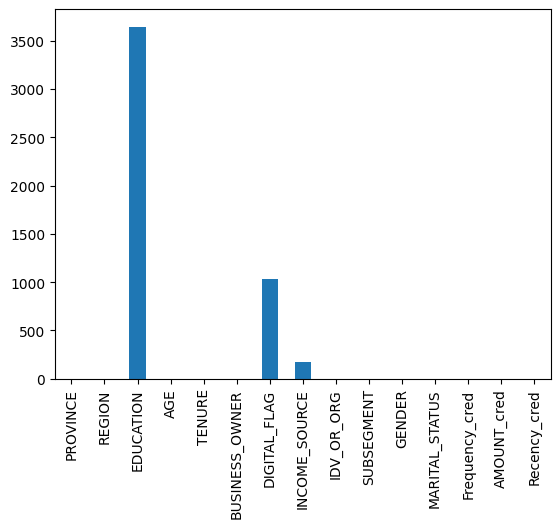

In [ ]:
merged_df_nulls.plot(kind='bar')
plt.show()

In [ ]:
total_merged_df = len(merged_df)
(merged_df_nulls / total_merged_df) * 100

PROVINCE          0.000000
REGION            0.000000
EDUCATION         9.198304
AGE               0.000000
TENURE            0.000000
BUSINESS_OWNER    0.000000
DIGITAL_FLAG      2.594911
INCOME_SOURCE     0.431644
IDV_OR_ORG        0.000000
SUBSEGMENT        0.000000
GENDER            0.000000
MARITAL_STATUS    0.000000
Frequency_cred    0.000000
AMOUNT_cred       0.000000
Recency_cred      0.000000
dtype: float64

#### Save to Parquet File

In [ ]:
merged_df.to_parquet("/content/drive/MyDrive/BPI Clustering Project/merged.parquet")